In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from PIL import Image
from tensorflow import keras

In [2]:
# define function to easily resize given images
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg") # file name to list, '*' for full text
    
    print(len(images), " images to be resized.")

    # reshaping all images to 28x28 and then saving each one of them
    target_size=(28, 28)
    for img in images:
        old_img=Image.open(img) # opening image
        new_img=old_img.resize(target_size,Image.ANTIALIAS) # resizing
        new_img.save(img, "JPEG") # saving image
    
    print(len(images), " images resized.")

# loading and resizing all images in scissor folder
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissors"
resize_images(image_dir_path)

# loading and resizing all images in rock folder
image_dir_path = os.getenv('HOME') + '/aiffel/rock_scissor_paper/rock'
resize_images(image_dir_path)

# loading and resizing all images in rock folder
image_dir_path = os.getenv('HOME') + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

700  images to be resized.
700  images resized.
700  images to be resized.
700  images resized.
700  images to be resized.
700  images resized.


In [3]:
# function to load all train data
def load_data(img_path, number_of_data=2100):  # ensure to double check the num of data
    img_size=28
    color=3
    # assigning imgs with zero only matrix of total params
    # scissors : 0, rock : 1, paper : 2
    
    # 1-d zero matrix of all params, then reshaping to 4-d tensor
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    # zero matrix for target
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32) # image data into np.array
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=0   # scissors : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=1   # rock : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=2   # paper : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2100 입니다.
x_train shape: (2100, 28, 28, 3)
y_train shape: (2100,)


라벨:  0


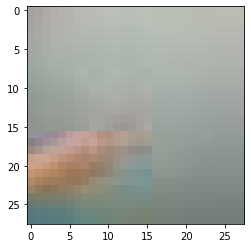

In [4]:
# quick check of the image
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [5]:
# all image and label loaded into x_train and y_train
# thus splitting parts of them as test sets using sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, stratify=y_train)

print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train)) # check min max of train data
print('최소값:',np.min(x_test), ' 최대값:',np.max(x_test)) # check min max of test data
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

최소값: 0  최대값: 255
최소값: 0  최대값: 255
(1785, 28, 28, 3) (315, 28, 28, 3) (1785,) (315,)


In [6]:
# normalizing train set
x_train_norm = x_train / np.max(x_train) # divide by max num to normalize data
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm)) # after normalizing
x_train_norm.shape

최소값: 0.0  최대값: 1.0


(1785, 28, 28, 3)

In [7]:
# normalizing test set
x_test_norm = x_test / np.max(x_test)   # divide by max num to normalize data
print('최소값:',np.min(x_test_norm), ' 최대값:',np.max(x_test_norm)) # after normalizing
x_test_norm.shape

최소값: 0.0  최대값: 1.0


(315, 28, 28, 3)

In [8]:
# constructing a model using keras
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (No

In [9]:
# training a model with method '.compile()' and '.fit()'
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=30, validation_split=0.15)

Epoch 1/30
48/48 [==============================] - 3s 9ms/step - loss: 1.0941 - accuracy: 0.3691 - val_loss: 1.0859 - val_accuracy: 0.4552
Epoch 2/30
48/48 [==============================] - 0s 4ms/step - loss: 1.0686 - accuracy: 0.4318 - val_loss: 1.0935 - val_accuracy: 0.3209
Epoch 3/30
48/48 [==============================] - 0s 4ms/step - loss: 1.0203 - accuracy: 0.4779 - val_loss: 0.9606 - val_accuracy: 0.5597
Epoch 4/30
48/48 [==============================] - 0s 4ms/step - loss: 0.9323 - accuracy: 0.5544 - val_loss: 0.8690 - val_accuracy: 0.6231
Epoch 5/30
48/48 [==============================] - 0s 4ms/step - loss: 0.8708 - accuracy: 0.5900 - val_loss: 0.8329 - val_accuracy: 0.5896
Epoch 6/30
48/48 [==============================] - 0s 4ms/step - loss: 0.8215 - accuracy: 0.6157 - val_loss: 0.7970 - val_accuracy: 0.6642
Epoch 7/30
48/48 [==============================] - 0s 4ms/step - loss: 0.8098 - accuracy: 0.6355 - val_loss: 0.7542 - val_accuracy: 0.6791
Epoch 8/30
48/48 [==

## NEED TO PLOT EPOCH, LOSS, and ACCURACY to easily see the overfitting point

In [10]:
# evaluate a model by using '.evaluate()' method
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.4595 - accuracy: 0.8063
test_loss: 0.4594825506210327
test_accuracy: 0.8063492178916931


# 회고

1회차
- 학습 이미지로 300개가 있었고, 테스트 이미지도 300장이 있어서 노드에 있는 이미지들로 프로젝트를 진행했었다.
- 결과가 30-40%대로 나왔어서 hyperparameter들을 만져보았다.
    - epoch를 조금씩 올리자 테스트 결과가 조금씩 좋아졌지만, 어느 순간부터는 과적합에 빠져서 오히려 내려가는 결과를 보였다.
    - 모델안에 hyperparameter들도 숫자를 올리면 조금씩 좋아지다가 내려가는 비슷한 경향을 보였다.
    - 반대로 hyperparameter 숫자들을 내려봤는데, 올리는 것보다 조금 더 좋아지는 경향을 보였다.
- 하지만 최대 40%후반에서 더 올라가지 않아서 정규화를 시도해보았다.
    - 결과는 눈꼽만큼 좋아졌지, 엄청나게 높아지지는 않았다.
- 계속 진행하다가, 우리 조 자체에서 다들 이미지를 취합해서 더 많은 데이터를 사용해보기로 결정을 했다.
    - 그렇게 총 2100개의 이미지 데이터를 얻을 수 있었다.
- 2100개의 데이터 자체를 sklearn.model_selection에 train_test_split을 이용하여 8:2로 나누었다.
    - epoch를 20으로 늘리고 hyperparameter를 처음 모델 만들 때 그대로 진행했더니 쉽게 기준치를 넘는 점수를 보여주었다.
    - 데이터가 많아짐에 따라 성능이 더 나온것으로 보인다

2회차
- 데이터 정규화, epoch=30, parameters 올리고 나서 최대 84%까지 증가
    - Random state를 정하지 않아서 매번 다른 값이 나오기에 최대값만 기억함
- sklearn에 train_test_split으로 train/validation/test로 나누어 보는 걸 해볼 예정
    - 문제가 데이터를 나눈 후 사용하는 방법을 모르겠다...
- 후에는 k-fold cross validation을 해볼 예정